![title](logo.png)

# WMC-03: MODELAGEM MATEMÁTICA E COMPUTACIONAL NA COVID-19
# Proponente: UFJF
## Ministrantes: Rodrigo Weber dos Santos (UFJF), Marcelo Lobosco (UFJF) e Bernardo Martins Rocha (UFJF)

# Introdução

Conteúdo dessa aula:

01. Conceitos preliminares (Python, Jupyter-Notebook, Bibliotecas)
02. Ajuste de curva
03. Modelo matemático de COVID-19
04. Simulação dos modelos baseados em EDOs
05. Ajuste de parâmetros dos modelos
06. Propagação de incertezas
07. Análise de sensibilidade

## Alguns links importantes

- Python: https://www.python.org/
- NumPy: https://numpy.org/
- Lmfit: https://lmfit.github.io/lmfit-py/
- ChaosPy: https://chaospy.readthedocs.io/en/master/
- SALib: https://salib.readthedocs.io/en/latest/

# Imports

In [2]:
import sys
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
!pip install numdifftools

# UQ e SA
!pip install chaospy
!pip install SAlib

import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Exemplo de Ajuste de Curva

Considere um exemplo onde se deseja ajustar a seguinte curva (distribuição normal com algum ruído):

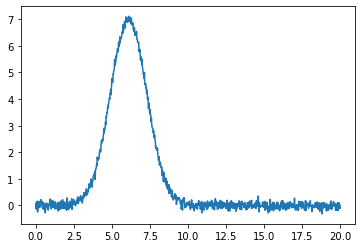

In [15]:
np.random.seed(123)
x = np.linspace(0, 20.0, 1001)

# dist normal com ruido
media = 6.1
dp = 1.2
data = (gaussian(x, 21, media, dp) + np.random.normal(scale=0.1, size=x.size))  
plt.plot(x, data);

Então, definimos uma função que recebe x como primeiro argumento, e os parâmetros a serem ajustados (a, b, c)

In [16]:
def f(x, a, b, c):
    return gaussian(x, a, b, c)

In [17]:
mod = lmfit.Model(f)

# parametros (e algumas aproximacoes iniciais)
mod.set_param_hint("a", value=10.0, vary=True)
mod.set_param_hint("b", value=10.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()

In [18]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 20.934832789418618, 'b': 6.099226997142615, 'c': 1.1981365549285588}

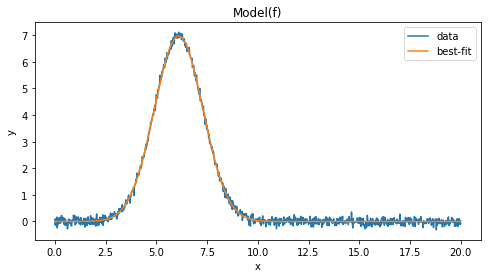

In [19]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [21]:
result

# Simulação de modelos matemáticos de COVID-19

Como visto nas outras aulas, alguns modelos de COVID-19 podem ser descritos como sistemas de equações diferenciais ordinárias (EDOs). O modelo mais simples para transmissão de doenças infecciosas é o modelo chamado SIR (Susceptible, Infectious, Recovered). Vamos apresentar as ideias com base nesse modelo.

## Modelo SIR (Susceptible, Infectious, or Recovered) 

$$
\begin{align}
\frac{d S}{d t} &=-\frac{\beta I S}{N} \\
\frac{d I}{d t} &=\frac{\beta I S}{N}-\gamma I \\
\frac{d R}{d t} &=\gamma I
\end{align}
$$

onde
- $S$: suscetíveis;
- $I$: infectados;
- $R$: recuperados;
- $N$: tamanho da população;
- $\beta$: taxa de transmissão;
- $\gamma$: taxa de recuperação.

## Simulação do modelo SIR

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sig
import seaborn as sns
from scipy.integrate import odeint
#sns.set()

def sir(xs, t, ps):
    """
    SIR model
    """
    try:
        N = ps['n'].value
        beta = ps['beta'].value
        gama = ps['gama'].value
    except:
        N, beta, gama = ps
    # equations
    S,I,R = xs
    dSdt = - beta*S*I/N
    dIdt = beta*S*I/N - gama*I
    dRdt = gama*I
    return np.array([dSdt, dIdt, dRdt])

def plot_sir(x, y, labels):
    plt.plot(x, y[:,0], lw=2, label=labels[0])
    plt.plot(x, y[:,1], lw=2, label=labels[1])
    plt.plot(x, y[:,2], lw=2, label=labels[2])
    plt.xlabel('tempo')
    plt.ylabel('populacao')
    plt.legend(loc='best')
    plt.show()

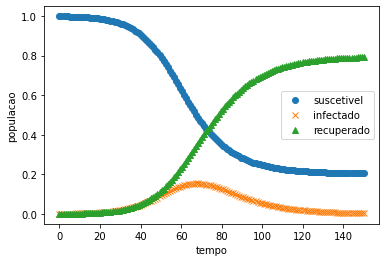

In [35]:
# parametros
N = 1000
beta = 0.2
gama = 0.1
params = (N,beta,gama)

# condicao inicial
i0, r0 = 1, 0
s0 = N-i0-r0

tf = 150
t = np.linspace(0,tf,150)
ts = (0, tf)
labels = ['suscetivel','infectado','recuperado']

# resolve EDOs
ic = np.array([s0,i0,r0])
X = odeint(sir, ic, t, args=(params,))

plot_sir(t, X/N, labels)

## Geração de dados sintéticos para exemplo de ajuste do modelo

In [31]:
def model(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) 
    with initial condition x(0) = x0
    """
    x = odeint(sir, x0, t, args=(ps,))
    return x

  S		 I		 R
[[9.99000000e+02 1.00000000e+00 0.00000000e+00]
 [9.98284957e+02 1.35703531e+00 3.58007351e-01]
 [9.97315686e+02 1.84060278e+00 8.43711684e-01]
 ...
 [2.05981166e+02 4.53381489e+00 7.89485019e+02]
 [2.05458603e+02 3.78629267e+00 7.90755105e+02]
 [2.05023278e+02 3.16109525e+00 7.91815627e+02]]


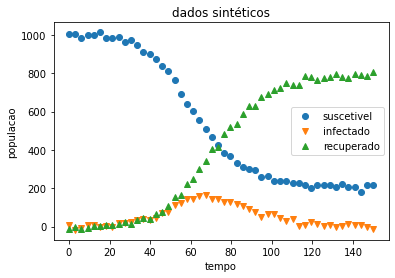

In [36]:
np.set_printoptions(threshold=10)

# parametros
true_params = np.array((N,beta,gama))

# condicao inicial
i0, r0 = 1, 0
s0 = N-i0-r0
ic = (s0,i0,r0)
tf = 150
t = np.linspace(0,tf,50)

# gera dados
data = model(t, ic, true_params)
print("  S\t\t I\t\t R")
print(data)

# adiciona ruido de media=0 e dp=10
data += np.random.normal(loc=0.0, scale=10.0, size=data.shape)

# plot dos dados
plt.plot(t, data[:,0], 'o', label='suscetivel')
plt.plot(t, data[:,1], 'v', label='infectado')
plt.plot(t, data[:,2], '^', label='recuperado')
plt.xlabel('tempo')
plt.ylabel('populacao')
plt.legend(loc='best')
plt.title("dados sintéticos")
plt.show()

## Ajuste de parâmetros do modelo SIR

In [37]:
def sir(xs, t, N, ps):
    """
    SIR model
    """
    try:
        beta = ps['beta'].value
        gama = ps['gama'].value
    except:
        beta, gama = ps
    # equations
    S,I,R = xs
    dSdt = - beta*S*I/N
    dIdt = beta*S*I/N - gama*I
    dRdt = gama*I
    return np.array([dSdt, dIdt, dRdt])

def model(t, x0, N, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) 
    with initial condition x(0) = x0
    """
    x = odeint(sir, x0, t, args=(N,ps))
    return x

def residual(ps, ts, ydata, N, ics):
    """
    Computes residual for NL least squares
    """
    ymodel = model(ts, ics, N, ps)
    return (ymodel - ydata).ravel()

def residual_i(ps, ts, ydata, N, ics):
    """
    Computes residual for NL least squares - infected only
    """
    ymodel = model(ts, ics, N, ps)
    return (ymodel[:,1] - ydata[:,1]) #.ravel()

Obs: O que faz essa função ravel() do Python/Numpy?

In [38]:
xx = np.array([[1, 2, 3], [4, 5, 6]])
print(np.shape(xx))
np.ravel(xx)

(2, 3)


array([1, 2, 3, 4, 5, 6])

In [66]:
from lmfit import minimize, Parameters, Parameter, report_fit

# =================================================================
# Caso 1 - Sintetico
# =================================================================

# parametros
N = 1000
beta = 0.2
gama = 0.1 
true_params = np.array((beta,gama))

# condicao inicial
i0, r0 = 1, 0
s0 = N-i0-r0
ic = (s0,i0,r0)

# tempo
tf = 150
t = np.linspace(0,tf,50)

# gera dados
data = model(t, ic, N, true_params)

# adiciona ruido de media=0 e dp=20
data += np.random.normal(loc=0.0, scale=10.0, size=data.shape)

# =================================================================
# Fitting
# =================================================================

# initial guess
params = Parameters()
params.add('beta', value=0.5, min=0, max=10)
params.add('gama', value=0.5, min=0, max=10)

# fitting
result = minimize(residual, params, args=(t, data, N, ic), method='leastsq')

#result = minimize(residual_i, params, args=(t, data, N, ic), method='leastsq')

# display fitted statistics
report_fit(result)

# plot fitted model
labels = ['suscetivel','infectado','recuperado']
final = model(t, ic, N, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 150
    # variables        = 2
    chi-square         = 15629.0156
    reduced chi-square = 105.601457
    Akaike info crit   = 700.937372
    Bayesian info crit = 706.958642
[[Variables]]
    beta:  0.19980945 +/- 7.3350e-04 (0.37%) (init = 0.5)
    gama:  0.10007320 +/- 6.5090e-04 (0.65%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gama) =  0.966


In [67]:
# =================================================================
# Resultados
# =================================================================

#result
result.params


name,value,standard error,relative error,initial value,min,max,vary
beta,0.19980945,7.3350e-04,(0.37%),0.5,0.00000000,10.0000000,True
gama,0.10007320,6.5090e-04,(0.65%),0.5,0.00000000,10.0000000,True


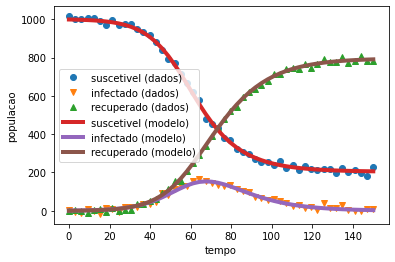

In [69]:
# plots
plt.plot(t, data[:,0], 'o', label=labels[0] + ' (dados)')
plt.plot(t, data[:,1], 'v', label=labels[1] + ' (dados)')
plt.plot(t, data[:,2], '^', label=labels[2] + ' (dados)')
plt.plot(t, final[:,0], '-', lw=4, label=labels[0] + ' (modelo)')
plt.plot(t, final[:,1], '-', lw=4, label=labels[1] + ' (modelo)')
plt.plot(t, final[:,2], '-', lw=4, label=labels[2] + ' (modelo)')
plt.xlabel('tempo')
plt.ylabel('populacao')
plt.legend(loc='best')
plt.show()

## Experimentos com o ajuste

- Aumentar o ruído/erro/incerteza nos dados
- Variar os valores iniciais dos parâmetros
- Variar o método utilizado (LM, DE, etc)
- Ajuste de parâmetros do modelo, seguido de previsão pelo modelo
- Ajuste de parâmetros do modelo utilizando dados reais (Notebook separado)

## Ajuste e previsão

In [74]:
# =================================================================
# Caso 2 - Sintetico - Ajuste + Previsao
# =================================================================

# parametros
N = 1000
beta = 0.2
gama = 0.1
true_params = np.array((beta,gama))

# condicao inicial
i0, r0 = 1, 0
s0 = N-i0-r0
ic = (s0,i0,r0)

# tempo
tf = 40
t = np.linspace(0,tf,50)

# gera dados
data = model(t, ic, N, true_params)

# adiciona ruido de media=0 e dp=10
data += np.random.normal(loc=0.0, scale=5.0, size=data.shape)

# =================================================================
# Fitting
# =================================================================

# initial guess
params = Parameters()
params.add('beta', value=0.5, min=0, max=10)
params.add('gama', value=0.5, min=0, max=10)

# fitting
result = minimize(residual, params, args=(t, data, N, ic), method='leastsq') #differential_evolution')
#result = minimize(residual_i, params, args=(t, data, N, ic), method='leastsq')

# display fitted statistics
#result
result.params

name,value,standard error,relative error,initial value,min,max,vary
beta,0.20333357,0.00420963,(2.07%),0.5,0.00000000,10.0000000,True
gama,0.10345070,0.00483963,(4.68%),0.5,0.00000000,10.0000000,True


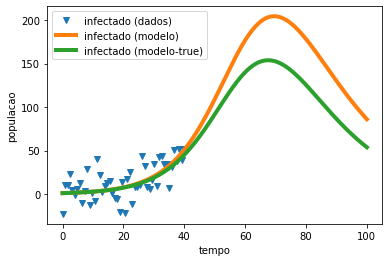

In [73]:
# previsao ate o tempo tf=100
tf = 100
tt = np.linspace(0,tf,200)

# avalia modelo ajustado
final_true = model(tt, ic, N, true_params)

# avalia modelo real/true
final_forecast = model(tt, ic, N, result.params)

# plot data + previsao + modelo real
plt.plot(t, data[:,1], 'v', label=labels[1] + ' (dados)')
plt.plot(tt, final_forecast[:,1], '-', lw=4, label=labels[1] + ' (modelo)')
plt.plot(tt, final_true[:,1], '-', lw=4, label=labels[1] + ' (modelo-true)')
plt.xlabel('tempo')
plt.ylabel('populacao')
plt.legend(loc='best')
plt.show()

# Propagação de Incertezas

Existem vários métodos que podem ser utilizados para realizar a propagação de incertezas dos parâmetros do modelo, porém o método mais simples e utilizado é o método de Monte Carlo (MC). Vamos ilustrar o seu uso nesse contexto de forma prática e simplificada.

Vamos considerar, por exemplo, que os parâmetros encontrados no ajuste possuam ambas incertezas de cerva de 5% (+/-). Isso não é necessariamente verdade, mas, para simplificar a apresentação, vamos considerar estes valores. 

Também iremos supor que os parâmetros sejam governados por distribuições uniformes. Sendo assim, temos:
- $\beta \sim U(0.19, 0.21)$
- $\gamma \sim U(0.095, 0.105)$

A ideia básica do método de MC é gerar amostras dos parâmetros e simular o modelo (forward model) para cada valor dessas amostras e no final extrair as estatísticas e informações de interesse a partir dos dados gerados.

Vamos ver como isso funciona através de um exemplo com o modelo SIR.

In [96]:
import chaospy as cp

# parametros
N = 1000
beta = 0.2
gama = 0.1

# condicao inicial
i0, r0 = 1, 0
s0 = N-i0-r0

tf = 150
size = 500
t = np.linspace(0,tf,size)
labels = ['suscetivel','infectado','recuperado']

# assumindo erro de 5% nos parametros
perc_beta = 0.01
perc_gama = 0.20

# distribuicao dos parametros
beta_l = beta - beta * perc_beta
beta_r = beta + beta * perc_beta
d_beta = cp.Uniform(beta_l, beta_r)

gama_l = gama - gama * perc_gama
gama_r = gama + gama * perc_gama
d_gama = cp.Uniform(gama_l, gama_r)

# distribuicao conjunta
dist = cp.J(d_beta, d_gama)
#print(dist)

# numero de amostras
nsamples = 100

# create vectors to contain the expectations and variances
samples = dist.sample(size=nsamples)
print(samples.T)
print(np.shape(samples.T))

[[0.19850274 0.1054408 ]
 [0.20068655 0.08251949]
 [0.19919621 0.08735227]
 ...
 [0.19997847 0.09795935]
 [0.20005175 0.11881006]
 [0.20041625 0.10448048]]
(100, 2)


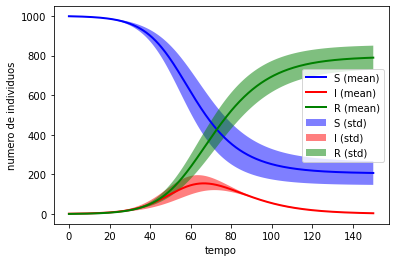

In [97]:
# solutions
sols_s = np.zeros((nsamples, size))
sols_i = np.zeros((nsamples, size))
sols_r = np.zeros((nsamples, size))
# mean values
exp_s = np.zeros(size)
exp_i = np.zeros(size)
exp_r = np.zeros(size)
# variance
var_s = np.zeros(size)
var_i = np.zeros(size)
var_r = np.zeros(size)

#
# Monte Carlo sampling 
# for each input sample
# compute the underlying solution)
#
for j, sample in enumerate(samples.T):
    #print(j,sample)
    
    # solve for this sample
    ic = np.array([s0,i0,r0])
    sol = model(t, ic, N, sample)
    #plot_sir(t, sol, labels)

    # store solution
    sols_s[j,:] = sol[:,0]
    sols_i[j,:] = sol[:,1]
    sols_r[j,:] = sol[:,2]

#    
# Compute statistics of the outputs at each time
#
for j in range(size):
    ss = sols_s[:,j]
    si = sols_i[:,j]
    sr = sols_r[:,j]
    exp_s[j] = np.mean(ss)
    exp_i[j] = np.mean(si)
    exp_r[j] = np.mean(sr)    
    var_s[j] = np.std(ss)   
    var_i[j] = np.std(si)   
    var_r[j] = np.std(sr)

# plot S
plt.plot(t, exp_s, lw=2, color='blue', label='S (mean)')
plt.fill_between(t, exp_s+var_s, exp_s-var_s, facecolor='blue', alpha=0.5, label='S (std)')
# plot I
plt.plot(t, exp_i, lw=2, color='red', label='I (mean)')
plt.fill_between(t, exp_i[:]+var_i[:], exp_i[:]-var_i, facecolor='red', alpha=0.5, label='I (std)')
# plot R
plt.plot(t, exp_r, lw=2, color='green', label='R (mean)')
plt.fill_between(t, exp_r+var_r, exp_r-var_r, facecolor='green', alpha=0.5, label='R (std)')
# plot settings
plt.xlabel("tempo")
plt.ylabel("numero de individuos")
plt.legend(loc='best')
plt.show()

# Análise de Sensibilidade

Análise de Sensibilidade baseada nos índices de Sobol.

O índice de sensibilidade de um parâmetro quantifica o seu impacto na incerteza da saída
Medem parte da variância da saída que podem ser atribuídas à variabilidade do parâmetro de entrada.

Índice de primeira-ordem (ou principal) e índice total.

Índice de Sobol de primeira-ordem $S_i$:

\begin{equation}
S_{i}=\frac{V\left[E\left(Y \mid X_{i}\right)\right]}{V(Y)}
\end{equation}

Propriedades: $S_i \in [0,1]$ e $\sum_{i} S_i \le 1$.

Índice de Sobol total $S_{T_i}$ (mede variações devido a interações de $x_i$ e outros parâmetros): 

\begin{equation}
S_{T_{i}}=\frac{E\left[V\left(Y \mid \mathbf{X}_{\sim i}\right)\right]}{V(Y)}=1-\frac{V\left[E\left(Y \mid \mathbf{X}_{\sim i}\right)\right]}{V(Y)}
\end{equation}

Veremos a seguir um exemplo de como se calcular estes índices de sensibilidade para o modelo SIR utilizando a biblioteca SAlib.

Para simplificar o tratamento, vamos considerar Y como um ponto da curva de S,I ou R.

In [98]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [125]:
N = 1000
problem = {
    "num_vars": 2,
    "names": [ "beta", "gama" ],
    "bounds": [ [0.19, 0.21], [0.095, 0.105] ]
}

# gera as amostras de entrada dos parametros
param_vals = saltelli.sample(problem, N, calc_second_order=True)
print(np.shape(param_vals))
print(param_vals)

(6000, 2)
[[0.1900293  0.09876465]
 [0.19895508 0.09876465]
 [0.1900293  0.09986816]
 ...
 [0.19313477 0.10007324]
 [0.19799805 0.10033691]
 [0.19799805 0.10007324]]


Observe que param_vals é uma matriz do NumPy cuja dimensão é 60000 by 2 para o caso com N=10000. O gerador de amostras de Saltelli gerou 60000 amostras.

O gerador de amostras de Saltelli gera N∗(2D+2) amostras, onde N é o número de 10000 é o argumento escolhido (para este exemplo) e D é 2 neste caso (o número de parâmetros de entrada). 

O argumento calc_second_order=False não irá calcular os índices de segunda ordem de Sobol (índice total), o que faz com que a matriz de amostras tenha apenas N∗(D+2) linhas.

In [126]:
# array para armazenar uma quantidade de interesse
# a ser avaliada pela analise de sensibilidade
Ns = param_vals.shape[0]
Y = np.empty([Ns])
print(np.shape(Y))

(6000,)


In [127]:
# configuracao do problema SIR
# parametros
Np = 1000

# condicao inicial
i0, r0 = 1, 0
s0 = Np-i0-r0

# tempo
tf = 150
size = 150
t = np.linspace(0,tf,size)

# avalia o modelo (SIR) para cada parâmetro de entrada
for i in range(Ns):
    x = param_vals[i]
    
    #print(f"amostra {i}: ", x)
    
    # resolve o problema SIR
    ic = np.array([s0,i0,r0])
    sol = model(t, ic, Np, x)
    
    # sol é uma matriz (npassos x 3)
    # 0-> suscetivel
    # 1-> infectado
    # 2-> recuperado
    
    # extrai a quantidade de interesse definida
    
    # num infectados no tempo t=60
    Y[i] = sol[60, 1]
    
    # num de recuperados no tempo t=60
    #Y[i] = sol[60, 2]
    
# fim do loop   

print("Amostras calculadas com sucesso")

Amostras calculadas com sucesso


In [128]:
print("Calculando indices de Sobol\n")

# estimate the sensitivity indices using Sobol's method
sensitivity = sobol.analyze(problem, Y, calc_second_order=True)

# firstorder indices
print("Indice de Sobol princial or de primeira ordem")
print(sensitivity['S1'])
print()

# higher-order indices
print("Indice de Sobol total ou de alta ordem")
print(sensitivity['ST'])

Calculando indices de Sobol

Indice de Sobol princial or de primeira ordem
[0.68462318 0.31698465]

Indice de Sobol total ou de alta ordem
[0.68210846 0.31513184]


## Cálculo dos índices de Sobol para todos instantes de tempo

In [115]:
# array para armazenar uma quantidade de interesse
# a ser avaliada pela analise de sensibilidade
Ns = param_vals.shape[0]
Ys = np.empty([Ns,size])
Yi = np.empty([Ns,size])
Yr = np.empty([Ns,size])

# avalia o modelo (SIR) para cada parâmetro de entrada
for i in range(Ns):
    x = param_vals[i]
    
    print(f"amostra {i}: ", x)
    
    # resolve o problema SIR
    ic = np.array([s0,i0,r0])
    sol = model(t, ic, Np, x)
    
    # sol é uma matriz (npassos x 3)
    # 0-> suscetivel
    # 1-> infectado
    # 2-> recuperado
    
    # extrai a quantidade de interesse definida
    Ys[i,:] = sol[:,0]
    Yi[i,:] = sol[:,1]
    Yr[i,:] = sol[:,2]    
    
# fim do loop   

print("Amostras calculadas com sucesso")

amostra 0:  [0.1900293  0.09876465]
amostra 1:  [0.19895508 0.09876465]
amostra 2:  [0.1900293  0.09986816]
amostra 3:  [0.1900293  0.09986816]
amostra 4:  [0.19895508 0.09876465]
amostra 5:  [0.19895508 0.09986816]
amostra 6:  [0.2000293  0.10376465]
amostra 7:  [0.20895508 0.10376465]
amostra 8:  [0.2000293  0.10486816]
amostra 9:  [0.2000293  0.10486816]
amostra 10:  [0.20895508 0.10376465]
amostra 11:  [0.20895508 0.10486816]
amostra 12:  [0.2050293  0.09626465]
amostra 13:  [0.19395508 0.09626465]
amostra 14:  [0.2050293  0.09736816]
amostra 15:  [0.2050293  0.09736816]
amostra 16:  [0.19395508 0.09626465]
amostra 17:  [0.19395508 0.09736816]
amostra 18:  [0.1950293  0.10126465]
amostra 19:  [0.20395508 0.10126465]
amostra 20:  [0.1950293  0.10236816]
amostra 21:  [0.1950293  0.10236816]
amostra 22:  [0.20395508 0.10126465]
amostra 23:  [0.20395508 0.10236816]
amostra 24:  [0.1975293  0.09501465]
amostra 25:  [0.20645508 0.09501465]
amostra 26:  [0.1975293  0.10111816]
amostra 27:

amostra 229:  [0.19301758 0.0951709 ]
amostra 230:  [0.2034668  0.09814941]
amostra 231:  [0.2034668  0.09814941]
amostra 232:  [0.19301758 0.0951709 ]
amostra 233:  [0.19301758 0.09814941]
amostra 234:  [0.1934668 0.1001709]
amostra 235:  [0.20301758 0.1001709 ]
amostra 236:  [0.1934668  0.10314941]
amostra 237:  [0.1934668  0.10314941]
amostra 238:  [0.20301758 0.1001709 ]
amostra 239:  [0.20301758 0.10314941]
amostra 240:  [0.1947168 0.0995459]
amostra 241:  [0.19426758 0.0995459 ]
amostra 242:  [0.1947168  0.10002441]
amostra 243:  [0.1947168  0.10002441]
amostra 244:  [0.19426758 0.0995459 ]
amostra 245:  [0.19426758 0.10002441]
amostra 246:  [0.2047168 0.1045459]
amostra 247:  [0.20426758 0.1045459 ]
amostra 248:  [0.2047168  0.09502441]
amostra 249:  [0.2047168  0.09502441]
amostra 250:  [0.20426758 0.1045459 ]
amostra 251:  [0.20426758 0.09502441]
amostra 252:  [0.2097168 0.0970459]
amostra 253:  [0.19926758 0.0970459 ]
amostra 254:  [0.2097168  0.10252441]
amostra 255:  [0.209

amostra 449:  [0.19129883 0.10104004]
amostra 450:  [0.19924805 0.10087402]
amostra 451:  [0.20129883 0.10087402]
amostra 452:  [0.19924805 0.09604004]
amostra 453:  [0.19924805 0.09604004]
amostra 454:  [0.20129883 0.10087402]
amostra 455:  [0.20129883 0.09604004]
amostra 456:  [0.19674805 0.09712402]
amostra 457:  [0.20879883 0.09712402]
amostra 458:  [0.19674805 0.09729004]
amostra 459:  [0.19674805 0.09729004]
amostra 460:  [0.20879883 0.09712402]
amostra 461:  [0.20879883 0.09729004]
amostra 462:  [0.20674805 0.10212402]
amostra 463:  [0.19879883 0.10212402]
amostra 464:  [0.20674805 0.10229004]
amostra 465:  [0.20674805 0.10229004]
amostra 466:  [0.19879883 0.10212402]
amostra 467:  [0.19879883 0.10229004]
amostra 468:  [0.20174805 0.09962402]
amostra 469:  [0.20379883 0.09962402]
amostra 470:  [0.20174805 0.09979004]
amostra 471:  [0.20174805 0.09979004]
amostra 472:  [0.20379883 0.09962402]
amostra 473:  [0.20379883 0.09979004]
amostra 474:  [0.19174805 0.10462402]
amostra 475:

amostra 736:  [0.20723633 0.09665527]
amostra 737:  [0.20723633 0.10244629]
amostra 738:  [0.19768555 0.10165527]
amostra 739:  [0.19723633 0.10165527]
amostra 740:  [0.19768555 0.09744629]
amostra 741:  [0.19768555 0.09744629]
amostra 742:  [0.19723633 0.10165527]
amostra 743:  [0.19723633 0.09744629]
amostra 744:  [0.19518555 0.09540527]
amostra 745:  [0.19473633 0.09540527]
amostra 746:  [0.19518555 0.09619629]
amostra 747:  [0.19518555 0.09619629]
amostra 748:  [0.19473633 0.09540527]
amostra 749:  [0.19473633 0.09619629]
amostra 750:  [0.20518555 0.10040527]
amostra 751:  [0.20473633 0.10040527]
amostra 752:  [0.20518555 0.10119629]
amostra 753:  [0.20518555 0.10119629]
amostra 754:  [0.20473633 0.10040527]
amostra 755:  [0.20473633 0.10119629]
amostra 756:  [0.20018555 0.09790527]
amostra 757:  [0.19973633 0.09790527]
amostra 758:  [0.20018555 0.09869629]
amostra 759:  [0.20018555 0.09869629]
amostra 760:  [0.19973633 0.09790527]
amostra 761:  [0.19973633 0.09869629]
amostra 762:

amostra 1021:  [0.19481445 0.09880371]
amostra 1022:  [0.20995117 0.10443848]
amostra 1023:  [0.20995117 0.10443848]
amostra 1024:  [0.19481445 0.09880371]
amostra 1025:  [0.19481445 0.10443848]
amostra 1026:  [0.19995117 0.10380371]
amostra 1027:  [0.20481445 0.10380371]
amostra 1028:  [0.19995117 0.09943848]
amostra 1029:  [0.19995117 0.09943848]
amostra 1030:  [0.20481445 0.10380371]
amostra 1031:  [0.20481445 0.09943848]
amostra 1032:  [0.19745117 0.09755371]
amostra 1033:  [0.20731445 0.09755371]
amostra 1034:  [0.19745117 0.09818848]
amostra 1035:  [0.19745117 0.09818848]
amostra 1036:  [0.20731445 0.09755371]
amostra 1037:  [0.20731445 0.09818848]
amostra 1038:  [0.20745117 0.10255371]
amostra 1039:  [0.19731445 0.10255371]
amostra 1040:  [0.20745117 0.10318848]
amostra 1041:  [0.20745117 0.10318848]
amostra 1042:  [0.19731445 0.10255371]
amostra 1043:  [0.19731445 0.10318848]
amostra 1044:  [0.20245117 0.09505371]
amostra 1045:  [0.20231445 0.09505371]
amostra 1046:  [0.2024511

amostra 1255:  [0.1915332  0.10169434]
amostra 1256:  [0.20229492 0.1020166 ]
amostra 1257:  [0.20229492 0.1020166 ]
amostra 1258:  [0.1915332  0.10169434]
amostra 1259:  [0.1915332 0.1020166]
amostra 1260:  [0.20729492 0.09919434]
amostra 1261:  [0.2065332  0.09919434]
amostra 1262:  [0.20729492 0.0995166 ]
amostra 1263:  [0.20729492 0.0995166 ]
amostra 1264:  [0.2065332  0.09919434]
amostra 1265:  [0.2065332 0.0995166]
amostra 1266:  [0.19729492 0.10419434]
amostra 1267:  [0.1965332  0.10419434]
amostra 1268:  [0.19729492 0.1045166 ]
amostra 1269:  [0.19729492 0.1045166 ]
amostra 1270:  [0.1965332  0.10419434]
amostra 1271:  [0.1965332 0.1045166]
amostra 1272:  [0.19979492 0.09794434]
amostra 1273:  [0.1940332  0.09794434]
amostra 1274:  [0.19979492 0.1032666 ]
amostra 1275:  [0.19979492 0.1032666 ]
amostra 1276:  [0.1940332  0.09794434]
amostra 1277:  [0.1940332 0.1032666]
amostra 1278:  [0.20979492 0.10294434]
amostra 1279:  [0.2040332  0.10294434]
amostra 1280:  [0.20979492 0.0982

amostra 1478:  [0.20385742 0.09623535]
amostra 1479:  [0.20385742 0.09623535]
amostra 1480:  [0.2055957  0.09810059]
amostra 1481:  [0.2055957  0.09623535]
amostra 1482:  [0.19385742 0.10310059]
amostra 1483:  [0.1955957  0.10310059]
amostra 1484:  [0.19385742 0.10123535]
amostra 1485:  [0.19385742 0.10123535]
amostra 1486:  [0.1955957  0.10310059]
amostra 1487:  [0.1955957  0.10123535]
amostra 1488:  [0.19260742 0.09747559]
amostra 1489:  [0.2068457  0.09747559]
amostra 1490:  [0.19260742 0.10311035]
amostra 1491:  [0.19260742 0.10311035]
amostra 1492:  [0.2068457  0.09747559]
amostra 1493:  [0.2068457  0.10311035]
amostra 1494:  [0.20260742 0.10247559]
amostra 1495:  [0.1968457  0.10247559]
amostra 1496:  [0.20260742 0.09811035]
amostra 1497:  [0.20260742 0.09811035]
amostra 1498:  [0.1968457  0.10247559]
amostra 1499:  [0.1968457  0.09811035]
amostra 1500:  [0.20760742 0.09997559]
amostra 1501:  [0.2018457  0.09997559]
amostra 1502:  [0.20760742 0.10061035]
amostra 1503:  [0.2076074

amostra 1699:  [0.20180664 0.10468262]
amostra 1700:  [0.19827148 0.09684082]
amostra 1701:  [0.19827148 0.09684082]
amostra 1702:  [0.20180664 0.10468262]
amostra 1703:  [0.20180664 0.09684082]
amostra 1704:  [0.19577148 0.09843262]
amostra 1705:  [0.20930664 0.09843262]
amostra 1706:  [0.19577148 0.09559082]
amostra 1707:  [0.19577148 0.09559082]
amostra 1708:  [0.20930664 0.09843262]
amostra 1709:  [0.20930664 0.09559082]
amostra 1710:  [0.20577148 0.10343262]
amostra 1711:  [0.19930664 0.10343262]
amostra 1712:  [0.20577148 0.10059082]
amostra 1713:  [0.20577148 0.10059082]
amostra 1714:  [0.19930664 0.10343262]
amostra 1715:  [0.19930664 0.10059082]
amostra 1716:  [0.20077148 0.09593262]
amostra 1717:  [0.20430664 0.09593262]
amostra 1718:  [0.20077148 0.09809082]
amostra 1719:  [0.20077148 0.09809082]
amostra 1720:  [0.20430664 0.09593262]
amostra 1721:  [0.20430664 0.09809082]
amostra 1722:  [0.19077148 0.10093262]
amostra 1723:  [0.19430664 0.10093262]
amostra 1724:  [0.1907714

amostra 1921:  [0.19102539 0.09976074]
amostra 1922:  [0.19061523 0.10379395]
amostra 1923:  [0.19061523 0.10379395]
amostra 1924:  [0.19102539 0.09976074]
amostra 1925:  [0.19102539 0.10379395]
amostra 1926:  [0.20061523 0.10476074]
amostra 1927:  [0.20102539 0.10476074]
amostra 1928:  [0.20061523 0.09879395]
amostra 1929:  [0.20061523 0.09879395]
amostra 1930:  [0.20102539 0.10476074]
amostra 1931:  [0.20102539 0.09879395]
amostra 1932:  [0.20561523 0.09726074]
amostra 1933:  [0.19602539 0.09726074]
amostra 1934:  [0.20561523 0.10129395]
amostra 1935:  [0.20561523 0.10129395]
amostra 1936:  [0.19602539 0.09726074]
amostra 1937:  [0.19602539 0.10129395]
amostra 1938:  [0.19561523 0.10226074]
amostra 1939:  [0.20602539 0.10226074]
amostra 1940:  [0.19561523 0.09629395]
amostra 1941:  [0.19561523 0.09629395]
amostra 1942:  [0.20602539 0.10226074]
amostra 1943:  [0.20602539 0.09629395]
amostra 1944:  [0.19811523 0.09601074]
amostra 1945:  [0.20352539 0.09601074]
amostra 1946:  [0.1981152

amostra 2145:  [0.20842773 0.0955127 ]
amostra 2146:  [0.20196289 0.10366699]
amostra 2147:  [0.20196289 0.0955127 ]
amostra 2148:  [0.20342773 0.09616699]
amostra 2149:  [0.19696289 0.09616699]
amostra 2150:  [0.20342773 0.1030127 ]
amostra 2151:  [0.20342773 0.1030127 ]
amostra 2152:  [0.19696289 0.09616699]
amostra 2153:  [0.19696289 0.1030127 ]
amostra 2154:  [0.19342773 0.10116699]
amostra 2155:  [0.20696289 0.10116699]
amostra 2156:  [0.19342773 0.0980127 ]
amostra 2157:  [0.19342773 0.0980127 ]
amostra 2158:  [0.20696289 0.10116699]
amostra 2159:  [0.20696289 0.0980127 ]
amostra 2160:  [0.19467773 0.09929199]
amostra 2161:  [0.19571289 0.09929199]
amostra 2162:  [0.19467773 0.0961377 ]
amostra 2163:  [0.19467773 0.0961377 ]
amostra 2164:  [0.19571289 0.09929199]
amostra 2165:  [0.19571289 0.0961377 ]
amostra 2166:  [0.20467773 0.10429199]
amostra 2167:  [0.20571289 0.10429199]
amostra 2168:  [0.20467773 0.1011377 ]
amostra 2169:  [0.20467773 0.1011377 ]
amostra 2170:  [0.2057128

amostra 2367:  [0.20897461 0.09711426]
amostra 2368:  [0.19282227 0.0985498 ]
amostra 2369:  [0.19282227 0.09711426]
amostra 2370:  [0.19897461 0.1035498 ]
amostra 2371:  [0.20282227 0.1035498 ]
amostra 2372:  [0.19897461 0.10211426]
amostra 2373:  [0.19897461 0.10211426]
amostra 2374:  [0.20282227 0.1035498 ]
amostra 2375:  [0.20282227 0.10211426]
amostra 2376:  [0.19647461 0.0997998 ]
amostra 2377:  [0.20532227 0.0997998 ]
amostra 2378:  [0.19647461 0.10086426]
amostra 2379:  [0.19647461 0.10086426]
amostra 2380:  [0.20532227 0.0997998 ]
amostra 2381:  [0.20532227 0.10086426]
amostra 2382:  [0.20647461 0.1047998 ]
amostra 2383:  [0.19532227 0.1047998 ]
amostra 2384:  [0.20647461 0.09586426]
amostra 2385:  [0.20647461 0.09586426]
amostra 2386:  [0.19532227 0.1047998 ]
amostra 2387:  [0.19532227 0.09586426]
amostra 2388:  [0.20147461 0.0972998 ]
amostra 2389:  [0.20032227 0.0972998 ]
amostra 2390:  [0.20147461 0.10336426]
amostra 2391:  [0.20147461 0.10336426]
amostra 2392:  [0.2003222

amostra 2634:  [0.19428711 0.10339355]
amostra 2635:  [0.19438477 0.10339355]
amostra 2636:  [0.19428711 0.09508301]
amostra 2637:  [0.19428711 0.09508301]
amostra 2638:  [0.19438477 0.10339355]
amostra 2639:  [0.19438477 0.09508301]
amostra 2640:  [0.19303711 0.09651855]
amostra 2641:  [0.20313477 0.09651855]
amostra 2642:  [0.19303711 0.09820801]
amostra 2643:  [0.19303711 0.09820801]
amostra 2644:  [0.20313477 0.09651855]
amostra 2645:  [0.20313477 0.09820801]
amostra 2646:  [0.20303711 0.10151855]
amostra 2647:  [0.19313477 0.10151855]
amostra 2648:  [0.20303711 0.10320801]
amostra 2649:  [0.20303711 0.10320801]
amostra 2650:  [0.19313477 0.10151855]
amostra 2651:  [0.19313477 0.10320801]
amostra 2652:  [0.20803711 0.09901855]
amostra 2653:  [0.20813477 0.09901855]
amostra 2654:  [0.20803711 0.09570801]
amostra 2655:  [0.20803711 0.09570801]
amostra 2656:  [0.20813477 0.09901855]
amostra 2657:  [0.20813477 0.09570801]
amostra 2658:  [0.19803711 0.10401855]
amostra 2659:  [0.1981347

amostra 2859:  [0.19600586 0.10406738]
amostra 2860:  [0.19860352 0.09894043]
amostra 2861:  [0.19860352 0.10406738]
amostra 2862:  [0.20600586 0.10394043]
amostra 2863:  [0.20860352 0.10394043]
amostra 2864:  [0.20600586 0.09906738]
amostra 2865:  [0.20600586 0.09906738]
amostra 2866:  [0.20860352 0.10394043]
amostra 2867:  [0.20860352 0.09906738]
amostra 2868:  [0.20100586 0.09644043]
amostra 2869:  [0.19360352 0.09644043]
amostra 2870:  [0.20100586 0.10156738]
amostra 2871:  [0.20100586 0.10156738]
amostra 2872:  [0.19360352 0.09644043]
amostra 2873:  [0.19360352 0.10156738]
amostra 2874:  [0.19100586 0.10144043]
amostra 2875:  [0.20360352 0.10144043]
amostra 2876:  [0.19100586 0.09656738]
amostra 2877:  [0.19100586 0.09656738]
amostra 2878:  [0.20360352 0.10144043]
amostra 2879:  [0.20360352 0.09656738]
amostra 2880:  [0.19069336 0.09909668]
amostra 2881:  [0.20891602 0.09909668]
amostra 2882:  [0.19069336 0.09859863]
amostra 2883:  [0.19069336 0.09859863]
amostra 2884:  [0.2089160

amostra 3081:  [0.20004883 0.09505371]
amostra 3082:  [0.19053711 0.10125488]
amostra 3083:  [0.19053711 0.09505371]
amostra 3084:  [0.20504883 0.09875488]
amostra 3085:  [0.20553711 0.09875488]
amostra 3086:  [0.20504883 0.10255371]
amostra 3087:  [0.20504883 0.10255371]
amostra 3088:  [0.20553711 0.09875488]
amostra 3089:  [0.20553711 0.10255371]
amostra 3090:  [0.19504883 0.10375488]
amostra 3091:  [0.19553711 0.10375488]
amostra 3092:  [0.19504883 0.09755371]
amostra 3093:  [0.19504883 0.09755371]
amostra 3094:  [0.19553711 0.10375488]
amostra 3095:  [0.19553711 0.09755371]
amostra 3096:  [0.19754883 0.09750488]
amostra 3097:  [0.19303711 0.09750488]
amostra 3098:  [0.19754883 0.09880371]
amostra 3099:  [0.19754883 0.09880371]
amostra 3100:  [0.19303711 0.09750488]
amostra 3101:  [0.19303711 0.09880371]
amostra 3102:  [0.20754883 0.10250488]
amostra 3103:  [0.20303711 0.10250488]
amostra 3104:  [0.20754883 0.10380371]
amostra 3105:  [0.20754883 0.10380371]
amostra 3106:  [0.2030371

amostra 3353:  [0.19272461 0.10364746]
amostra 3354:  [0.19223633 0.10078613]
amostra 3355:  [0.20272461 0.10078613]
amostra 3356:  [0.19223633 0.09864746]
amostra 3357:  [0.19223633 0.09864746]
amostra 3358:  [0.20272461 0.10078613]
amostra 3359:  [0.20272461 0.09864746]
amostra 3360:  [0.19161133 0.09609863]
amostra 3361:  [0.19584961 0.09609863]
amostra 3362:  [0.19161133 0.10145996]
amostra 3363:  [0.19161133 0.10145996]
amostra 3364:  [0.19584961 0.09609863]
amostra 3365:  [0.19584961 0.10145996]
amostra 3366:  [0.20161133 0.10109863]
amostra 3367:  [0.20584961 0.10109863]
amostra 3368:  [0.20161133 0.09645996]
amostra 3369:  [0.20161133 0.09645996]
amostra 3370:  [0.20584961 0.10109863]
amostra 3371:  [0.20584961 0.09645996]
amostra 3372:  [0.20661133 0.09859863]
amostra 3373:  [0.19084961 0.09859863]
amostra 3374:  [0.20661133 0.10395996]
amostra 3375:  [0.20661133 0.10395996]
amostra 3376:  [0.19084961 0.09859863]
amostra 3377:  [0.19084961 0.10395996]
amostra 3378:  [0.1966113

amostra 3572:  [0.19739258 0.09747559]
amostra 3573:  [0.19739258 0.09747559]
amostra 3574:  [0.20850586 0.10492676]
amostra 3575:  [0.20850586 0.09747559]
amostra 3576:  [0.19989258 0.09867676]
amostra 3577:  [0.20100586 0.09867676]
amostra 3578:  [0.19989258 0.09622559]
amostra 3579:  [0.19989258 0.09622559]
amostra 3580:  [0.20100586 0.09867676]
amostra 3581:  [0.20100586 0.09622559]
amostra 3582:  [0.20989258 0.10367676]
amostra 3583:  [0.19100586 0.10367676]
amostra 3584:  [0.20989258 0.10122559]
amostra 3585:  [0.20989258 0.10122559]
amostra 3586:  [0.19100586 0.10367676]
amostra 3587:  [0.19100586 0.10122559]
amostra 3588:  [0.20489258 0.09617676]
amostra 3589:  [0.20600586 0.09617676]
amostra 3590:  [0.20489258 0.09872559]
amostra 3591:  [0.20489258 0.09872559]
amostra 3592:  [0.20600586 0.09617676]
amostra 3593:  [0.20600586 0.09872559]
amostra 3594:  [0.19489258 0.10117676]
amostra 3595:  [0.19600586 0.10117676]
amostra 3596:  [0.19489258 0.10372559]
amostra 3597:  [0.1948925

amostra 3804:  [0.20770508 0.09914551]
amostra 3805:  [0.19319336 0.09914551]
amostra 3806:  [0.20770508 0.09763184]
amostra 3807:  [0.20770508 0.09763184]
amostra 3808:  [0.19319336 0.09914551]
amostra 3809:  [0.19319336 0.09763184]
amostra 3810:  [0.19770508 0.10414551]
amostra 3811:  [0.20319336 0.10414551]
amostra 3812:  [0.19770508 0.10263184]
amostra 3813:  [0.19770508 0.10263184]
amostra 3814:  [0.20319336 0.10414551]
amostra 3815:  [0.20319336 0.10263184]
amostra 3816:  [0.19520508 0.09789551]
amostra 3817:  [0.20569336 0.09789551]
amostra 3818:  [0.19520508 0.10388184]
amostra 3819:  [0.19520508 0.10388184]
amostra 3820:  [0.20569336 0.09789551]
amostra 3821:  [0.20569336 0.10388184]
amostra 3822:  [0.20520508 0.10289551]
amostra 3823:  [0.19569336 0.10289551]
amostra 3824:  [0.20520508 0.09888184]
amostra 3825:  [0.20520508 0.09888184]
amostra 3826:  [0.19569336 0.10289551]
amostra 3827:  [0.19569336 0.09888184]
amostra 3828:  [0.20020508 0.09539551]
amostra 3829:  [0.2006933

amostra 4040:  [0.2012207 0.1023584]
amostra 4041:  [0.2012207 0.1023584]
amostra 4042:  [0.20952148 0.10191895]
amostra 4043:  [0.20952148 0.1023584 ]
amostra 4044:  [0.2062207  0.09941895]
amostra 4045:  [0.19452148 0.09941895]
amostra 4046:  [0.2062207 0.0998584]
amostra 4047:  [0.2062207 0.0998584]
amostra 4048:  [0.19452148 0.09941895]
amostra 4049:  [0.19452148 0.0998584 ]
amostra 4050:  [0.1962207  0.10441895]
amostra 4051:  [0.20452148 0.10441895]
amostra 4052:  [0.1962207 0.1048584]
amostra 4053:  [0.1962207 0.1048584]
amostra 4054:  [0.20452148 0.10441895]
amostra 4055:  [0.20452148 0.1048584 ]
amostra 4056:  [0.1987207  0.09816895]
amostra 4057:  [0.20702148 0.09816895]
amostra 4058:  [0.1987207 0.1036084]
amostra 4059:  [0.1987207 0.1036084]
amostra 4060:  [0.20702148 0.09816895]
amostra 4061:  [0.20702148 0.1036084 ]
amostra 4062:  [0.2087207  0.10316895]
amostra 4063:  [0.19702148 0.10316895]
amostra 4064:  [0.2087207 0.0986084]
amostra 4065:  [0.2087207 0.0986084]
amostr

amostra 4275:  [0.19418945 0.09587402]
amostra 4276:  [0.20874023 0.09762207]
amostra 4277:  [0.20874023 0.09587402]
amostra 4278:  [0.20418945 0.10262207]
amostra 4279:  [0.19874023 0.10262207]
amostra 4280:  [0.20418945 0.10087402]
amostra 4281:  [0.20418945 0.10087402]
amostra 4282:  [0.19874023 0.10262207]
amostra 4283:  [0.19874023 0.10087402]
amostra 4284:  [0.20918945 0.09512207]
amostra 4285:  [0.20374023 0.09512207]
amostra 4286:  [0.20918945 0.09837402]
amostra 4287:  [0.20918945 0.09837402]
amostra 4288:  [0.20374023 0.09512207]
amostra 4289:  [0.20374023 0.09837402]
amostra 4290:  [0.19918945 0.10012207]
amostra 4291:  [0.19374023 0.10012207]
amostra 4292:  [0.19918945 0.10337402]
amostra 4293:  [0.19918945 0.10337402]
amostra 4294:  [0.19374023 0.10012207]
amostra 4295:  [0.19374023 0.10337402]
amostra 4296:  [0.19668945 0.09637207]
amostra 4297:  [0.19624023 0.09637207]
amostra 4298:  [0.19668945 0.10462402]
amostra 4299:  [0.19668945 0.10462402]
amostra 4300:  [0.1962402

amostra 4501:  [0.20467773 0.09652832]
amostra 4502:  [0.20200195 0.09728027]
amostra 4503:  [0.20200195 0.09728027]
amostra 4504:  [0.20467773 0.09652832]
amostra 4505:  [0.20467773 0.09728027]
amostra 4506:  [0.19200195 0.10152832]
amostra 4507:  [0.19467773 0.10152832]
amostra 4508:  [0.19200195 0.10228027]
amostra 4509:  [0.19200195 0.10228027]
amostra 4510:  [0.19467773 0.10152832]
amostra 4511:  [0.19467773 0.10228027]
amostra 4512:  [0.19137695 0.09684082]
amostra 4513:  [0.20655273 0.09684082]
amostra 4514:  [0.19137695 0.09759277]
amostra 4515:  [0.19137695 0.09759277]
amostra 4516:  [0.20655273 0.09684082]
amostra 4517:  [0.20655273 0.09759277]
amostra 4518:  [0.20137695 0.10184082]
amostra 4519:  [0.19655273 0.10184082]
amostra 4520:  [0.20137695 0.10259277]
amostra 4521:  [0.20137695 0.10259277]
amostra 4522:  [0.19655273 0.10184082]
amostra 4523:  [0.19655273 0.10259277]
amostra 4524:  [0.20637695 0.09934082]
amostra 4525:  [0.20155273 0.09934082]
amostra 4526:  [0.2063769

amostra 4717:  [0.19151367 0.09904785]
amostra 4718:  [0.20696289 0.0963623 ]
amostra 4719:  [0.20696289 0.0963623 ]
amostra 4720:  [0.19151367 0.09904785]
amostra 4721:  [0.19151367 0.0963623 ]
amostra 4722:  [0.19696289 0.10404785]
amostra 4723:  [0.20151367 0.10404785]
amostra 4724:  [0.19696289 0.1013623 ]
amostra 4725:  [0.19696289 0.1013623 ]
amostra 4726:  [0.20151367 0.10404785]
amostra 4727:  [0.20151367 0.1013623 ]
amostra 4728:  [0.19946289 0.09779785]
amostra 4729:  [0.20901367 0.09779785]
amostra 4730:  [0.19946289 0.1001123 ]
amostra 4731:  [0.19946289 0.1001123 ]
amostra 4732:  [0.20901367 0.09779785]
amostra 4733:  [0.20901367 0.1001123 ]
amostra 4734:  [0.20946289 0.10279785]
amostra 4735:  [0.19901367 0.10279785]
amostra 4736:  [0.20946289 0.0951123 ]
amostra 4737:  [0.20946289 0.0951123 ]
amostra 4738:  [0.19901367 0.10279785]
amostra 4739:  [0.19901367 0.0951123 ]
amostra 4740:  [0.20446289 0.09529785]
amostra 4741:  [0.20401367 0.09529785]
amostra 4742:  [0.2044628

amostra 4948:  [0.19182617 0.0970166 ]
amostra 4949:  [0.19182617 0.10120605]
amostra 4950:  [0.20290039 0.1020166 ]
amostra 4951:  [0.20182617 0.1020166 ]
amostra 4952:  [0.20290039 0.09620605]
amostra 4953:  [0.20290039 0.09620605]
amostra 4954:  [0.20182617 0.1020166 ]
amostra 4955:  [0.20182617 0.09620605]
amostra 4956:  [0.20790039 0.0995166 ]
amostra 4957:  [0.19682617 0.0995166 ]
amostra 4958:  [0.20790039 0.10370605]
amostra 4959:  [0.20790039 0.10370605]
amostra 4960:  [0.19682617 0.0995166 ]
amostra 4961:  [0.19682617 0.10370605]
amostra 4962:  [0.19790039 0.1045166 ]
amostra 4963:  [0.20682617 0.1045166 ]
amostra 4964:  [0.19790039 0.09870605]
amostra 4965:  [0.19790039 0.09870605]
amostra 4966:  [0.20682617 0.1045166 ]
amostra 4967:  [0.20682617 0.09870605]
amostra 4968:  [0.19540039 0.0982666 ]
amostra 4969:  [0.20432617 0.0982666 ]
amostra 4970:  [0.19540039 0.09995605]
amostra 4971:  [0.19540039 0.09995605]
amostra 4972:  [0.20432617 0.0982666 ]
amostra 4973:  [0.2043261

amostra 5173:  [0.20135742 0.09693848]
amostra 5174:  [0.20118164 0.09894043]
amostra 5175:  [0.20118164 0.09894043]
amostra 5176:  [0.20135742 0.09693848]
amostra 5177:  [0.20135742 0.09894043]
amostra 5178:  [0.19118164 0.10193848]
amostra 5179:  [0.19135742 0.10193848]
amostra 5180:  [0.19118164 0.10394043]
amostra 5181:  [0.19118164 0.10394043]
amostra 5182:  [0.19135742 0.10193848]
amostra 5183:  [0.19135742 0.10394043]
amostra 5184:  [0.19086914 0.09990723]
amostra 5185:  [0.19604492 0.09990723]
amostra 5186:  [0.19086914 0.10065918]
amostra 5187:  [0.19086914 0.10065918]
amostra 5188:  [0.19604492 0.09990723]
amostra 5189:  [0.19604492 0.10065918]
amostra 5190:  [0.20086914 0.10490723]
amostra 5191:  [0.20604492 0.10490723]
amostra 5192:  [0.20086914 0.09565918]
amostra 5193:  [0.20086914 0.09565918]
amostra 5194:  [0.20604492 0.10490723]
amostra 5195:  [0.20604492 0.09565918]
amostra 5196:  [0.20586914 0.09740723]
amostra 5197:  [0.19104492 0.09740723]
amostra 5198:  [0.2058691

amostra 5395:  [0.2025293  0.10291504]
amostra 5396:  [0.19516602 0.09733887]
amostra 5397:  [0.19516602 0.09733887]
amostra 5398:  [0.2025293  0.10291504]
amostra 5399:  [0.2025293  0.09733887]
amostra 5400:  [0.19766602 0.09916504]
amostra 5401:  [0.2050293  0.09916504]
amostra 5402:  [0.19766602 0.09608887]
amostra 5403:  [0.19766602 0.09608887]
amostra 5404:  [0.2050293  0.09916504]
amostra 5405:  [0.2050293  0.09608887]
amostra 5406:  [0.20766602 0.10416504]
amostra 5407:  [0.1950293  0.10416504]
amostra 5408:  [0.20766602 0.10108887]
amostra 5409:  [0.20766602 0.10108887]
amostra 5410:  [0.1950293  0.10416504]
amostra 5411:  [0.1950293  0.10108887]
amostra 5412:  [0.20266602 0.09666504]
amostra 5413:  [0.2000293  0.09666504]
amostra 5414:  [0.20266602 0.09858887]
amostra 5415:  [0.20266602 0.09858887]
amostra 5416:  [0.2000293  0.09666504]
amostra 5417:  [0.2000293  0.09858887]
amostra 5418:  [0.19266602 0.10166504]
amostra 5419:  [0.1900293  0.10166504]
amostra 5420:  [0.1926660

amostra 5635:  [0.2078418  0.10369629]
amostra 5636:  [0.19985352 0.10280762]
amostra 5637:  [0.19985352 0.10280762]
amostra 5638:  [0.2078418  0.10369629]
amostra 5639:  [0.2078418  0.10280762]
amostra 5640:  [0.19735352 0.09994629]
amostra 5641:  [0.2003418  0.09994629]
amostra 5642:  [0.19735352 0.10405762]
amostra 5643:  [0.19735352 0.10405762]
amostra 5644:  [0.2003418  0.09994629]
amostra 5645:  [0.2003418  0.10405762]
amostra 5646:  [0.20735352 0.10494629]
amostra 5647:  [0.1903418  0.10494629]
amostra 5648:  [0.20735352 0.09905762]
amostra 5649:  [0.20735352 0.09905762]
amostra 5650:  [0.1903418  0.10494629]
amostra 5651:  [0.1903418  0.09905762]
amostra 5652:  [0.20235352 0.09744629]
amostra 5653:  [0.2053418  0.09744629]
amostra 5654:  [0.20235352 0.10155762]
amostra 5655:  [0.20235352 0.10155762]
amostra 5656:  [0.2053418  0.09744629]
amostra 5657:  [0.2053418  0.10155762]
amostra 5658:  [0.19235352 0.10244629]
amostra 5659:  [0.1953418  0.10244629]
amostra 5660:  [0.1923535

amostra 5865:  [0.20219727 0.09522949]
amostra 5866:  [0.19581055 0.10080566]
amostra 5867:  [0.19581055 0.09522949]
amostra 5868:  [0.20719727 0.09830566]
amostra 5869:  [0.20081055 0.09830566]
amostra 5870:  [0.20719727 0.10272949]
amostra 5871:  [0.20719727 0.10272949]
amostra 5872:  [0.20081055 0.09830566]
amostra 5873:  [0.20081055 0.10272949]
amostra 5874:  [0.19719727 0.10330566]
amostra 5875:  [0.19081055 0.10330566]
amostra 5876:  [0.19719727 0.09772949]
amostra 5877:  [0.19719727 0.09772949]
amostra 5878:  [0.19081055 0.10330566]
amostra 5879:  [0.19081055 0.09772949]
amostra 5880:  [0.19969727 0.09955566]
amostra 5881:  [0.19831055 0.09955566]
amostra 5882:  [0.19969727 0.09897949]
amostra 5883:  [0.19969727 0.09897949]
amostra 5884:  [0.19831055 0.09955566]
amostra 5885:  [0.19831055 0.09897949]
amostra 5886:  [0.20969727 0.10455566]
amostra 5887:  [0.20831055 0.10455566]
amostra 5888:  [0.20969727 0.10397949]
amostra 5889:  [0.20969727 0.10397949]
amostra 5890:  [0.2083105

Calculando indices de Sobol

OK


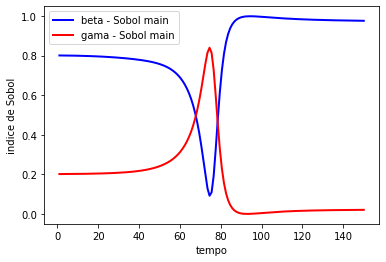

In [120]:
print("Calculando indices de Sobol\n")

Ss = np.empty([2,size])
Si = np.empty([2,size])
Sr = np.empty([2,size])

for j in range(size):
   
    # estimate the sensitivity indices using Sobol's method
    sens_s = sobol.analyze(problem, Ys[:,j], calc_second_order=True)
    sens_i = sobol.analyze(problem, Yi[:,j], calc_second_order=True)
    sens_r = sobol.analyze(problem, Yr[:,j], calc_second_order=True)

    Ss[:,j] = sens_s['S1']
    Si[:,j] = sens_i['S1']
    Sr[:,j] = sens_r['S1']
    #print(j)

print("OK")

# plot sobol indices for Infectados
plt.plot(t, Si[0,:], lw=2, color='blue', label='beta - Sobol main')
plt.plot(t, Si[1,:], lw=2, color='red', label='gama - Sobol main')

# plot settings
plt.xlabel("tempo")
plt.ylabel("indice de Sobol")
plt.legend(loc='best')
plt.show()

# Algumas observações

- Tanto na propagação de incertezas (UQ direta) quanto na análise de sensibilidade (SA) foi preciso escolher um intervalo para os parâmetros de entrada.

- Aqui nessa aula, essa escolha foi feita de forma simplificada.

- O ideal é obter essas informações após o ajuste dos parâmetros (lmfit fornece algumas estimativas).

- Uma abordagem mais apropriada é utilizar métodos de quantificação de incertezas inversa (UQ inversa), a qual fornece uma distribuição de probabilidade para cada parâmetro. Quanto maior a dispersão dessa distribuição para um determinado parâmetro, maior a incerteza deste parâmetro. Ex: Markov-Chain Monte-Carlo.

# Contatos

Email
- bernardomartinsrocha@ice.ufjf.br

Repositório no GitHub:
- https://github.com/rochabm/curso_sbpc_2021

# Referências

- Livro "An Introduction to Infectious Disease Modelling". Autores: Emilia Vynnycky, Richard White
- Livro "Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers". Autor: Ryan G. McClarren
- Livro "Global Sensitivity Analysis. The Primer - Andrea Saltelli" (Obs: disponível para download no site do autor)
- Site "Towards Data Science"
- https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7
- https://medium.com/analytics-vidhya/coronavirus-in-italy-ode-model-an-parameter-optimization-forecast-with-python-c1769cf7a511